# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 74661.28 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 106093.28 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 125222.26 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 136016.18 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 142686.21 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 150341.81 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 77403.75 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 110437.61 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 126523.63 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 135069.85 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 139307.59 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 151692.57 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.16 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.23 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.77 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.01 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.79 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.90 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.70 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.64 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.50 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.42 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.50 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.08 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.44 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.96 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.44 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.80 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.30 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.66 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.30 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.95 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.24 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.19 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.74 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.61 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.81 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.60 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 34.77 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.84 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 25.76 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 33.20 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 38.88 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 42.67 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.29 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.37 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.19 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.06 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.42 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.62 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.74 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.74 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.39 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.52 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.16 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.68 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.26 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.63 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.73 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.26 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.89 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.98 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.31 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.44 examples/s]

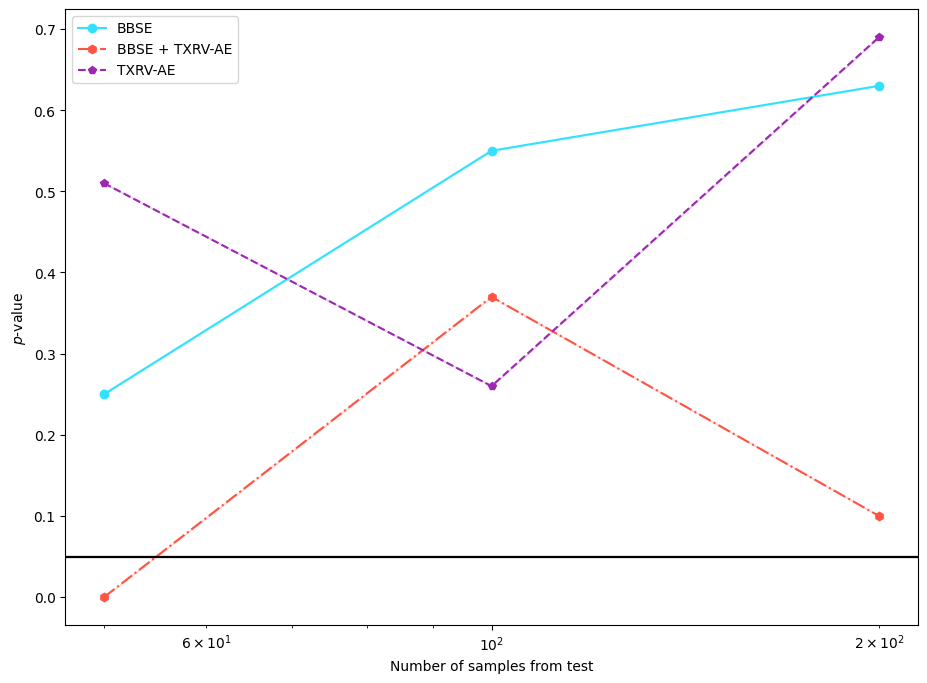

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.06 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.19 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.17 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.96 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.32 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.49 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.40 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.26 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.34 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.35 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.54 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.92 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.49 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.67 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.34 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.62 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 49.03 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.43 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.97 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.07 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.67 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.09 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.52 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.88 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.62 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.31 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.67 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.42 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.75 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.30 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.93 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.25 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.16 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.81 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.20 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.48 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.59 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.10 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.50 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.46 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.83 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.87 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.20 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.42 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.53 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.41 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.48 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.13 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.82 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.19 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.74 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.23 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.66 examples/s]

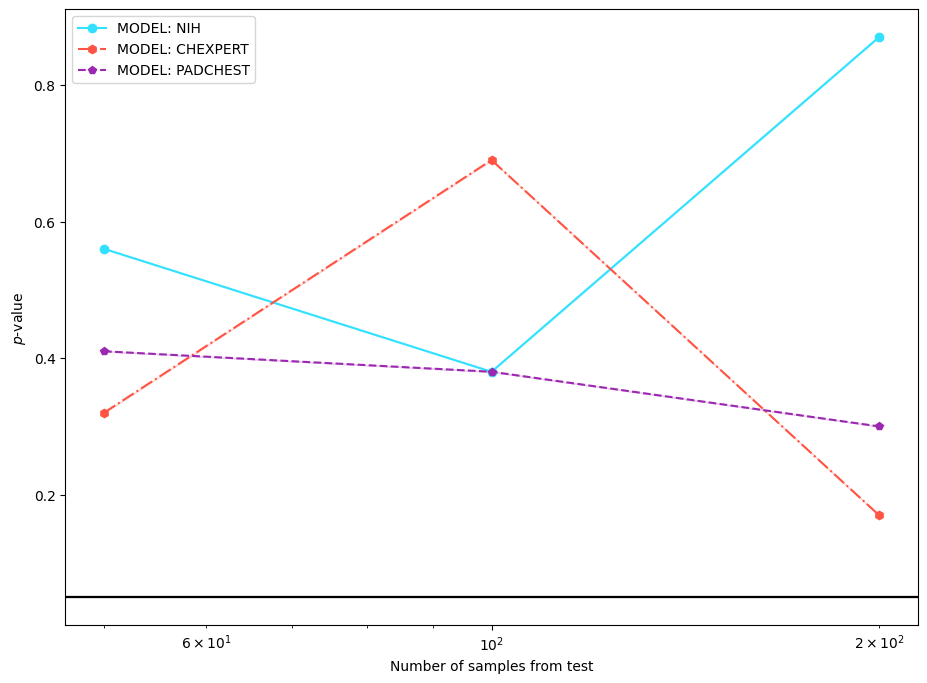

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53140.22 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72858.54 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 81596.97 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 87861.84 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 89683.04 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 92390.65 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48096.02 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 63505.93 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 74710.44 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 83517.89 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 94226.27 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 102562.49 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.27 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.69 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.46 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.81 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.39 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.58 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.65 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.31 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.91 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.49 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.57 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.55 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.07 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.62 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.23 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 49145.77 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 65410.70 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 75795.04 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 83920.37 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 93631.22 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 101103.48 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48689.81 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 67826.69 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 79784.94 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 85323.61 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 90330.59 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 92701.57 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.31 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.29 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.80 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.23 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.53 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.91 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.79 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.07 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.65 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.86 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.92 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.41 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.16 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.65 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.56 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.90 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.58 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.33 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48634.46 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 65117.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 75522.50 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:01<00:00, 82033.10 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 86585.48 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 89474.12 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 45915.56 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 62888.41 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 69424.74 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:01<00:00, 78788.32 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 83858.74 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 87945.19 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.08 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.57 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.59 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.94 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.15 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.45 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.22 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.46 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.28 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.88 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.30 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.52 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.41 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.94 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.18 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.96 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.62 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.90 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.65 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51564.09 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71751.29 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 79995.55 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 85089.72 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 87631.08 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 90117.80 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:02, 45612.15 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 63180.12 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 72960.28 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:01<00:00, 80395.90 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 85434.58 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 89275.71 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.27 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.16 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.68 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.69 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.68 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.77 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.42 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.61 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.93 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.72 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.63 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.13 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.45 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.41 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.18 examples/s]

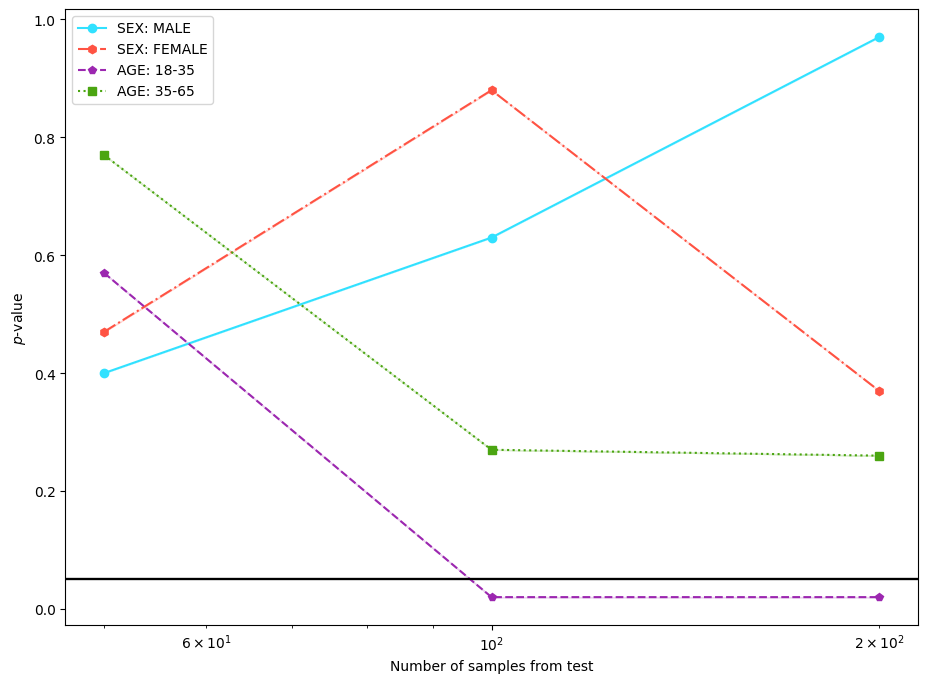

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.18 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.86 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.60 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.70 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.89 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.54 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.44 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.53 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.58 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.22 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.26 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.19 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.35 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.51 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.76 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.95 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.78 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.69 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.95 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.23 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.22 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.41 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.86 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.23 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.38 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.52 examples/s]

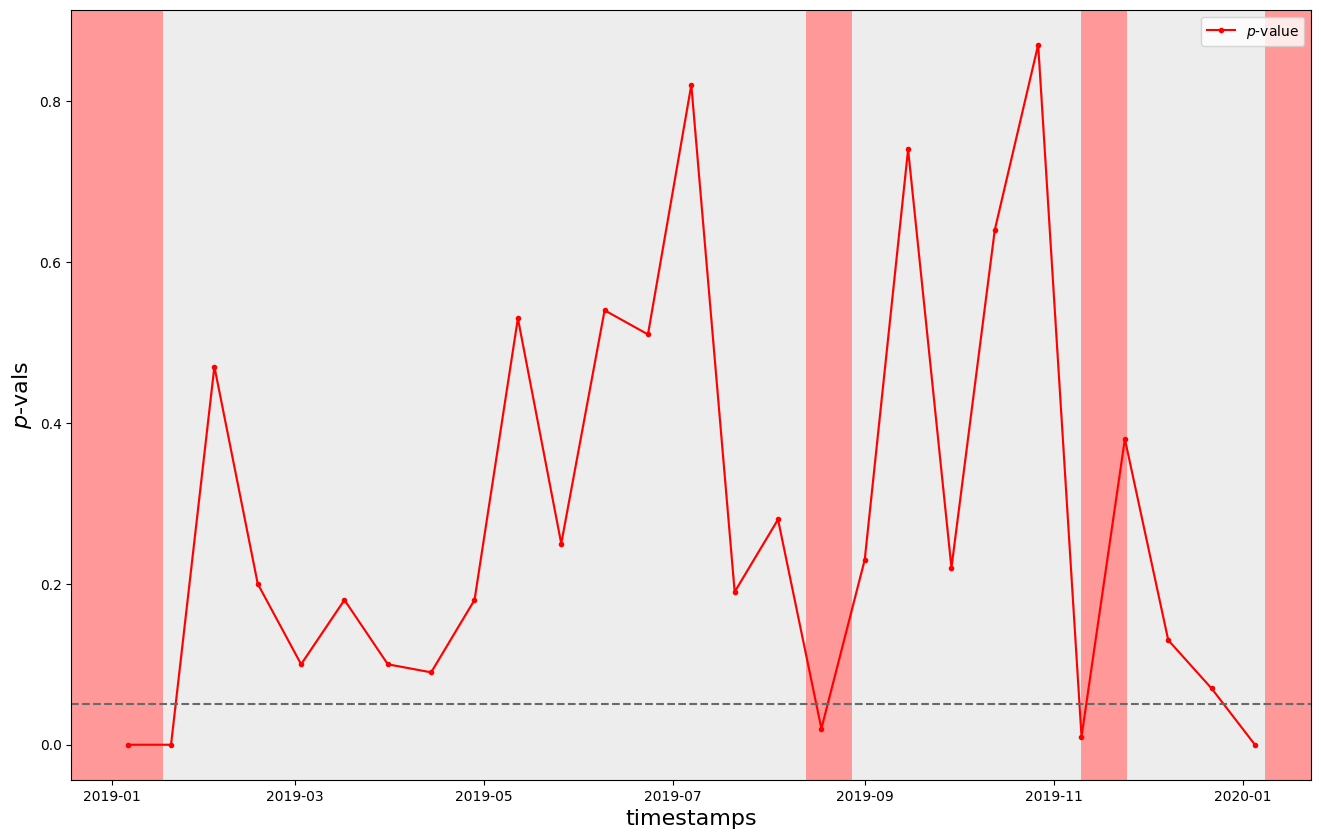

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)